In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import *

In [2]:
with open('data_clean/filesIDV.pickle', 'rb') as f:
    files_idv = pickle.load(f)

In [3]:
treatment = []
#start.callData.call.request.treatment=none
for file in files_idv:
    with open(file) as f:
        for line in f.readlines():
            if 'request.treatment' in line:
                treat = line.split('=')[1].rstrip()
                treatment.append(treat)
                break

In [4]:
counter_treatment = Counter(treatment)
(counter_treatment['loans'] + counter_treatment['bus'] + counter_treatment['ccard'])/len(files_idv)

0.08792688030949176

In [5]:
idv_logs = []
for file in files_idv:
    entry={'file': file.as_posix()}
    with open(file) as f:
        for line in f.readlines():
            if line.startswith('start'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('end'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('end.callData.cti.outbound.oid'):
                x,y = line.split('=')
                entry['id'] = y.rstrip()
            
        idv_logs.append(entry)

idv_logs_df = pd.DataFrame.from_dict(idv_logs).drop(['request_module'],axis=1)
idv_logs_df.dropna(subset=['end_duration'],inplace=True)
idv_logs_df['end_duration'] = idv_logs_df['end_duration'].apply(lambda x: float(x[:-1]))

#idv_logs_df.replace(r'^\s*$', 'none', regex=True,inplace=True)

# 4 fifferent types of 
outbound = [col for col in idv_logs_df.columns if col.startswith('outbound')]
pd.concat((idv_logs_df[outbound]['outbound_call_result'].value_counts(normalize = True), idv_logs_df[outbound]['outbound_call_result'].value_counts(normalize = False)),axis=1)

outbound_call_result  outbound_call_result
OK                      0.634268                 56042
Hangup                  0.245006                 21648
Error                   0.112985                  9983
Disconnect              0.007741                   684

In [6]:
files_idv_ok         = idv_logs_df.query('outbound_call_result == "OK"')['file'].tolist()
files_idv_hangup     = idv_logs_df.query('outbound_call_result == "Hangup"')['file'].tolist()
files_idv_error      = idv_logs_df.query('outbound_call_result == "Error"')['file'].tolist()
files_idv_disconnect = idv_logs_df.query('outbound_call_result == "Disconnect"')['file'].tolist()

In [111]:
with open('data_clean/filesIDV_ok.pickle', 'wb') as f:
    pickle.dump(files_idv_ok,f)

with open('data_clean/filesIDV_hangup.pickle', 'wb') as f:
    pickle.dump(files_idv_hangup,f)
    
with open('data_clean/filesIDV_error.pickle', 'wb') as f:
    pickle.dump(files_idv_error,f)
    
with open('data_clean/filesIDV_disconnect.pickle', 'wb') as f:
    pickle.dump(files_idv_disconnect,f)

In [7]:
# Checking consitnency
count = 0
for file in files_idv_disconnect:
    with open(file) as f:
        for line in f.readlines():
            if "Thank you. Goodbye." in line:
                    count+=1
count == len(files_idv_disconnect)

True

In [8]:
entry = {}
entries=[]
for file in files_idv:
        entry = {}
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        entry['file'] = file
        entry['Duration'] = (end_time - start_time).total_seconds()
        entries.append(entry)

In [156]:
np.mean([dur['Duration'] for dur in entries])

42.61232084883997

In [246]:
persistence = {}
for k in range(1,16):
    print(k)
    entries = []
    for file in files_idv:
        entry = {}
        flag = False
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith(f'rec[{k}]'):
                    flag = True  

                if line.startswith(f'rec[{k+1}]'):
                    flag = False

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if flag:
            entry['file'] = file
            entry['Duration'] = (end_time - start_time).total_seconds()
            entries.append(entry)
                    #files_hungup_open_menu.append(file)
    persistence[k] = entries

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [248]:
persistence_numbers = [len(e) for e in persistence.values()]
sum([(i+1)*val for i, val in enumerate(persistence_numbers)])/sum([val for i, val in enumerate(persistence_numbers)])

3.4075879777835594

In [256]:
sum([sum([item['Duration'] for item in value]) for key, value in persistence.items()])/len(files_idv)

42.61232084883997

In [257]:
persistence_hangup = {}
for k in range(1,16):
    print(k)
    entries = []
    for file in files_idv_hangup:
        entry = {}
        flag = False
        with open(file) as f:
            for line in f.readlines():
                if line.startswith('start.time'):
                    start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')

                if line.startswith(f'rec[{k}]'):
                    flag = True  

                if line.startswith(f'rec[{k+1}]'):
                    flag = False

                if line.startswith('end.time'):
                    end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if flag:
            entry['file'] = file
            entry['Duration'] = (end_time - start_time).total_seconds()
            entries.append(entry)
                    #files_hungup_open_menu.append(file)
    persistence_hangup[k] = entries

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [263]:
len(persistence_hangup[14])

0

In [266]:
sum([sum([item['Duration'] for item in value]) for key, value in persistence_hangup.items()])/len(files_idv_hangup)

23.76519770879527

## HUNGUP

### 1 Overal Picture

In [11]:
random.shuffle(files_idv_hangup)
show_file(files_idv_hangup[0])


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\WLG_04_23\23\12\124445-2EF71F4C45E7CD54CCCA674BCC6D4D07\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\WLG_04_23\23\12\124445-2EF71F4C45E7CD54CCCA674BCC6D4D07\kbva.calllog
#=====================================================================
start.time=23/04/2019 12:44:45.939
start.sessionID=2EF71F4C45E7CD54CCCA674BCC6D4D07
start.callData.call.request.dnis=44951903
start.callData.call.request.env=swn
start.callData.call.request.module=idv
start.callData.call.request.ref=152783.20649
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=23/04/2019 12:44:46.126
rec[1].state=GetAccessNumber
rec[1].reason=OK
rec[1].inputmode=dtmf
rec[1].utterance[1]=SUPPRESSED
rec[1].endTime=23/04/2019 12:45:11.767
re

In [8]:
len(files_idv_hangup)/len(files_idv)

0.24487856746942976

In [9]:
treatment = []
#start.callData.call.request.treatment=none
for file in files_idv_hangup:
    with open(file) as f:
        for line in f.readlines():
            if 'request.treatment' in line:
                treat = line.split('=')[1].rstrip()
                treatment.append(treat)
                break

In [10]:
counter_treatment = Counter(treatment)
(counter_treatment['loans'] + counter_treatment['bus'] + counter_treatment['ccard'])/len(files_idv_hangup)

0.0422209903917221

In [76]:
# how many reached open menue
files_hungup_open_menu = []
count = 0
for file in files_idv_hangup:
    with open(file) as f:
        for line in f.readlines():
            if "state=OpenMenu" in line:
                count += 1
                files_hungup_open_menu.append(file)
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)
print("{0:.2f}%".format(count/len(files_idv_hangup)*100))

8041
37.14%


In [101]:
(8041 - 462)/8041

0.9425444596443229

In [95]:
random.shuffle(files_hungup_open_menu)
show_file(files_hungup_open_menu[0])


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_04_30\30\14\140816-60602072A32CADBCA6C05FE34DBD345C\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_04_30\30\14\140816-60602072A32CADBCA6C05FE34DBD345C\kbva.calllog
#=====================================================================
start.time=30/04/2019 14:08:16.074
start.sessionID=60602072A32CADBCA6C05FE34DBD345C
start.callData.call.request.dnis=94405925
start.callData.call.request.env=sak
start.callData.call.request.module=idv
start.callData.call.request.ref=152790.26400
start.callData.call.request.treatment=ccard
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=30/04/2019 14:08:16.184
rec[1].state=GetAccessNumber
rec[1].reason=OK
rec[1].inputmode=dtmf
rec[1].utterance[1]=SUPPRESSED
rec[1].endTime=30/04/2019 14:08:36.309
r

In [102]:
# how many reached VerifyDateOfBirth
files_hungup_know_veri = []
count = 0
for file in files_hungup_open_menu:
    with open(file) as f:
        for line in f.readlines():
            if 'state=VerifyDateOfBirth' in line:
                files_hungup_know_veri.append(file)
                count += 1
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)
print(count/len(files_idv_hangup))

462
0.021341463414634148


In [332]:
show_file(files_idv[0])


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_04_23\23\07\070023-F8FC35BD72CF82D575EC0252C600AE93\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_04_23\23\07\070023-F8FC35BD72CF82D575EC0252C600AE93\kbva.calllog
#=====================================================================
start.time=23/04/2019 07:00:23.714
start.sessionID=F8FC35BD72CF82D575EC0252C600AE93
start.callData.call.request.dnis=94405903
start.callData.call.request.env=sak
start.callData.call.request.module=idv
start.callData.call.request.ref=152783.1893
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=23/04/2019 07:00:23.808
rec[1].state=GetAccessNumber
rec[1].reason=OK
rec[1].inputmode=dtmf
rec[1].utterance[1]=SUPPRESSED
rec[1].endTime=23/04/2019 07:00:34.282
rec

### 2 Dropping from different stages 

In [103]:
dropping_lines = []
for file in files_idv_hangup:
    lines = open(file).readlines()
    k = -1
    for line in lines:
        k+=1
        if "reason=HUNGUP" in line:
            dropping_lines.append(lines[k-2].rstrip())
            break

In [105]:
drop_out_rates = [(state.split('.')[0], state.split('=')[1], count) for state, count in Counter([line for line in  dropping_lines]).most_common()]
drop_out_rates_df = pd.DataFrame(drop_out_rates, columns=['rec','state','count'])

In [185]:
#
drop_state = (drop_out_rates_df.groupby('state')['count'].sum().sort_values(ascending=False)/len(files_idv_hangup)).to_frame(name='Dropout Rate') #.map(lambda n: '{:.2%}'.format(n))

call_steering_states = [ver for ver in drop_state.index if '_' in ver]
verify_states = [ver for ver in drop_state.index if ver.startswith('Verify')]

In [186]:
drop_state=pd.concat([drop_state.reset_index(),drop_state.reset_index()['state'].apply(lambda x: 'Steering' if '_' in x else None)],axis=1)

drop_state.columns = ['State','Dropout Rate', 'State2']

In [187]:
drop_state

State  Dropout Rate    State2
0                 GetAccessNumber      0.579869      None
1                        OpenMenu      0.335504      None
2                       VerifyPin      0.034507      None
3               VerifyDateOfBirth      0.016676      None
4             ConfirmAccessNumber      0.014181      None
5            Balance_IsCreditCard      0.002679  Steering
6              VerifyMobileNumber      0.002263      None
7               SLM_GetCallReason      0.002079  Steering
8                VerifyStreetName      0.001894      None
9              Payment_GetProduct      0.001848  Steering
10                Loan_GetPurpose      0.001617  Steering
11     InternetBanking_GetPurpose      0.001201  Steering
12             Account_GetProduct      0.001201  Steering
13          CreditCard_GetPurpose      0.001062  Steering
14               VerifyMiddleName      0.000508      None
15        PhoneBanking_GetPurpose      0.000416  Steering
16         Statement_IsCreditCard      0.000416  Steering
17    AutomaticPayment_GetPurpose      0.000323  Steering
18           Insurance_GetPurpose      0.000277  Steering
19            SLM_GetBranchReason      0.000231  Steering
20              Card_IsCreditCard      0.000185  Steering
21           CreditLimit_IsChange      0.000185  Steering
22                 CreditCard_New      0.000139  Steering
23         Airpoints_IsCreditCard      0.000139  Steering
24    Business_IsKiwibankCustomer      0.000092  Steering
25  NewAccount_IsKiwibankCustomer      0.000092  Steering
26           MobileApp_GetPurpose      0.000092  Steering
27     Insurance_GetProductDetail      0.000092  Steering
28           Kiwisaver_GetPurpose      0.000092  Steering
29      Transactions_IsCreditCard      0.000046  Steering
30        CreditCard_LostOrStolen      0.000046  Steering
31                Overdraft_IsNew      0.000046  Steering

In [206]:
x=drop_state.query('State2 == "Steering"')['Dropout Rate'].sum()
drop_state2 = drop_state[drop_state['State2'].isna()][['State','Dropout Rate']]
drop_state2.set_index('State',inplace=True)
drop_state2.loc['OpenMenu'] = drop_state2.loc['OpenMenu'] + x

In [216]:
drop_state2

Dropout Rate
State                            
GetAccessNumber          0.579869
OpenMenu                 0.350102
VerifyPin                0.034507
VerifyDateOfBirth        0.016676
ConfirmAccessNumber      0.014181
VerifyMobileNumber       0.002263
VerifyStreetName         0.001894
VerifyMiddleName         0.000508

In [214]:
drop_state2.loc['GetAccessNumber'] + drop_state2.loc['ConfirmAccessNumber'] + drop_state2.loc['VerifyPin']

Dropout Rate    0.628557
dtype: float64

In [245]:
(21648*.63)/len(files_idv)

0.15427349750574076

In [244]:
21648*.35/65410

0.11583549915914997

In [271]:
#Knowledge verification
21648*.02/11826

0.03661085743277524

### FLuxes

In [229]:
drop_out_rates_df

rec                          state  count
0     rec[1]                GetAccessNumber   8946
1     rec[3]                       OpenMenu   3529
2     rec[2]                GetAccessNumber   2400
3     rec[4]                       OpenMenu   1450
4     rec[2]                       OpenMenu   1360
5     rec[5]                       OpenMenu    556
6     rec[3]                GetAccessNumber    515
7     rec[2]                      VerifyPin    502
8     rec[5]                GetAccessNumber    321
9     rec[2]            ConfirmAccessNumber    219
10    rec[4]                GetAccessNumber    208
11    rec[6]                       OpenMenu    178
12    rec[6]                GetAccessNumber    132
13    rec[3]                      VerifyPin    128
14    rec[7]                       OpenMenu    123
15    rec[4]              VerifyDateOfBirth    108
16    rec[5]              VerifyDateOfBirth     98
17    rec[4]                      VerifyPin     72
18    rec[6]              VerifyDateOfBirth     64
19    rec[8]                       OpenMenu     61
20    rec[3]            ConfirmAccessNumber     57
21    rec[3]              VerifyDateOfBirth     47
22    rec[5]                      VerifyPin     28
23    rec[7]              VerifyDateOfBirth     26
24    rec[4]           Balance_IsCreditCard     25
25    rec[7]                GetAccessNumber     23
26    rec[4]            ConfirmAccessNumber     21
27    rec[4]              SLM_GetCallReason     21
28    rec[4]             Payment_GetProduct     20
29    rec[3]           Balance_IsCreditCard     16
..       ...                            ...    ...
99    rec[5]     Insurance_GetProductDetail      1
100   rec[4]    Business_IsKiwibankCustomer      1
101   rec[9]               VerifyMiddleName      1
102  rec[12]               VerifyStreetName      1
103   rec[5]         Statement_IsCreditCard      1
104  rec[10]             VerifyMobileNumber      1
105   rec[4]      Transactions_IsCreditCard      1
106   rec[7]    AutomaticPayment_GetPurpose      1
107   rec[7]    Business_IsKiwibankCustomer      1
108   rec[3]    AutomaticPayment_GetPurpose      1
109   rec[7]                Loan_GetPurpose      1
110   rec[4]                Overdraft_IsNew      1
111   rec[4]  NewAccount_IsKiwibankCustomer      1
112   rec[7]         Airpoints_IsCreditCard      1
113   rec[6]           Insurance_GetPurpose      1
114   rec[7]        PhoneBanking_GetPurpose      1
115   rec[7]     Insurance_GetProductDetail      1
116   rec[8]              SLM_GetCallReason      1
117   rec[6]    AutomaticPayment_GetPurpose      1
118   rec[6]              SLM_GetCallReason      1
119   rec[3]  NewAccount_IsKiwibankCustomer      1
120  rec[11]               VerifyStreetName      1
121   rec[5]    AutomaticPayment_GetPurpose      1
122   rec[7]            ConfirmAccessNumber      1
123   rec[6]          CreditCard_GetPurpose      1
124   rec[8]             Payment_GetProduct      1
125   rec[3]           Insurance_GetPurpose      1
126   rec[8]          CreditCard_GetPurpose      1
127   rec[4]        CreditCard_LostOrStolen      1
128   rec[6]                 CreditCard_New      1

[129 rows x 3 columns]

In [218]:
GetAccessNumber_df = drop_out_rates_df.query('state == "GetAccessNumber"').sort_values('rec')
GetAccessNumber_df.index = range(1,10)

In [221]:
access_number_lines = []
for file in files_idv:
    lines = open(file).readlines()
    k = -1
    for line in lines:
        k+=1
        if "state=GetAccessNumber" in line:
            dropping_lines.append(lines[k-2].rstrip())

In [222]:
counts_access_number_lines = {}
for k in range(1,10):
    count=0
    for file in files_idv:
        with open(file) as f:
            for line in f.readlines():
                if line.startswith(f'rec[{k}]') and 'GetAccessNumber' in line:
                    count += 1
                    #files_hungup_open_menu.append(file)
                    break
    counts_access_number_lines[k] = count
    print(k,count)

1 88403
2 13279
3 7371
4 2106
5 1877
6 740
7 152
8 37
9 8


In [224]:
GetAccessNumber_df2 = pd.concat([GetAccessNumber_df, pd.DataFrame.from_dict(counts_access_number_lines,orient='index')],axis=1)
GetAccessNumber_df2.columns = ['rec','state','count','total_count']

pd.concat([GetAccessNumber_df2,GetAccessNumber_df2['count']/GetAccessNumber_df2['total_count']],axis=1)

rec            state  count  total_count         0
1  rec[1]  GetAccessNumber   8946        88403  0.101196
2  rec[2]  GetAccessNumber   2400        13279  0.180737
3  rec[3]  GetAccessNumber    515         7371  0.069868
4  rec[4]  GetAccessNumber    208         2106  0.098765
5  rec[5]  GetAccessNumber    321         1877  0.171018
6  rec[6]  GetAccessNumber    132          740  0.178378
7  rec[7]  GetAccessNumber     23          152  0.151316
8  rec[8]  GetAccessNumber      4           37  0.108108
9  rec[9]  GetAccessNumber      4            8  0.500000

In [225]:
counts_openmenu_lines = {}
for k in range(2,11):
    count=0
    for file in files_idv:
        with open(file) as f:
            for line in f.readlines():
                if line.startswith(f'rec[{k}]') and 'OpenMenu' in line:
                    count += 1
                    #files_hungup_open_menu.append(file)
                    break
    counts_openmenu_lines[k] = count
    print(k,count)

2 18653
3 36928
4 14436
5 5509
6 1872
7 1404
8 609
9 136
10 37


In [219]:
OpenMenu_df = drop_out_rates_df.query('state == "OpenMenu"')
OpenMenu_df['rec_i'] = OpenMenu_df.copy()['rec'].apply(lambda x: int(re.findall(r'\d+',x)[0]))
OpenMenu_df = OpenMenu_df.sort_values('rec_i')
OpenMenu_df.index = range(2,11)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [228]:
OpenMenu_df2 = pd.concat([OpenMenu_df, pd.DataFrame.from_dict(counts_openmenu_lines,orient='index')],axis=1)
OpenMenu_df2.columns = ['rec','state','count','rec_i','total_count']

pd.concat([OpenMenu_df2,OpenMenu_df2['count']/OpenMenu_df2['total_count']],axis=1)

rec     state  count  rec_i  total_count         0
2    rec[2]  OpenMenu   1360      2        18653  0.072911
3    rec[3]  OpenMenu   3529      3        36928  0.095564
4    rec[4]  OpenMenu   1450      4        14436  0.100443
5    rec[5]  OpenMenu    556      5         5509  0.100926
6    rec[6]  OpenMenu    178      6         1872  0.095085
7    rec[7]  OpenMenu    123      7         1404  0.087607
8    rec[8]  OpenMenu     61      8          609  0.100164
9    rec[9]  OpenMenu      4      9          136  0.029412
10  rec[10]  OpenMenu      2     10           37  0.054054

## Customer Paths

In [10]:
states = []
for file in files_idv_hangup:
    lines = open(file).readlines()
    for line in lines:
        if "state=" in line:
            states.append(line.split('=')[1].rstrip())
states = set(states)

In [11]:
states_map = {key:value for value, key in enumerate(states)}

In [380]:
paths=[]
for file in files_idv:
    entry = {'file':file}
    path = ''
    lines = open(file).readlines()
    for line in lines:
        if "state=" in line:
            #path+= ',' + ''.join([c for c in line.split('=')[1].rstrip() if c.isupper()])
            state = line.split('=')[1].rstrip()
            if "_" in state:
               state =  'CallSteering'
            if 'Verify' in state and 'VerifyPin' not in state:
               state = 'KnowledgeVerify'
            
            path+= '_' +  state
    entry['path'] = path[1:]
    paths.append(entry)
paths_ALL = [p for p in [p['path'].split('_') for p in paths]]

In [367]:
paths=[]
for file in files_idv:
    entry = {'file':file}
    path = ''
    lines = open(file).readlines()
    for line in lines:
        if "state=" in line:
            #path+= ',' + ''.join([c for c in line.split('=')[1].rstrip() if c.isupper()])
            state = line.split('=')[1].rstrip()
            #if "_" in state:
            #    state =  'CallSteering'
            #if 'Verify' in state and 'VerifyPin' not in state:
            #    state = 'KnowledgeVerify'
            
            path+= ',' +  state
    entry['path'] = path[1:]
    paths.append(entry)
paths_ALL = [p for p in [p['path'].split(',') for p in paths]]

In [369]:
np.mean([len(p) == len(set(p)) for p in paths_ALL])

0.6077395563498976

In [371]:
len(paths_OK) + len(paths_HANGUP) + len(paths_DISCONNECT) + len(paths_ERROR)

88357

In [15]:
files_hangup_ID = [p['file'] for p in paths if 'OpenMenu' not in p['path']]
files_hangup_OM = list(set([p['file'] for p in paths if 'KnowledgeVerify' not in p['path']]) - set(files_hangup_ID))
files_hangup_KV = list(set([p['file'] for p in paths if 'KnowledgeVerify' in p['path']]) - set(files_hangup_OM))


In [16]:
random.shuffle(files_hangup_KV)
show_file(files_hangup_KV[0])


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\WLG_04_30\30\09\091829-122C64FCC89E9D94543451B0E63AC486\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\WLG_04_30\30\09\091829-122C64FCC89E9D94543451B0E63AC486\kbva.calllog
#=====================================================================
start.time=30/04/2019 09:18:29.874
start.sessionID=122C64FCC89E9D94543451B0E63AC486
start.callData.call.request.dnis=44951904
start.callData.call.request.env=swn
start.callData.call.request.module=idv
start.callData.call.request.ref=152790.10865
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=30/04/2019 09:18:29.952
rec[1].state=GetAccessNumber
rec[1].reason=OK
rec[1].inputmode=dtmf
rec[1].utterance[1]=SUPPRESSED
rec[1].endTime=30/04/2019 09:18:51.203
re

In [1238]:
times = []
for file in files_hangup_ID:
    lines = open(file).readlines()
    for line in lines:
        if 'start.time' in line:
            start_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if 'end.time' in line:
            end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
    dt_ = (end_time - start_time).total_seconds()
    times.append(dt_)
    
np.mean(times)

15.653781142059234

In [1239]:
times = []
for file in files_hangup_OM:
    k=-1
    lines = open(file).readlines()
    for line in lines:
        k+=1
        if 'state=OpenMenu' in line:
            start_time = dt.datetime.strptime(lines[k-1].split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if 'end.time' in line:
            end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
    dt_ = (end_time - start_time).total_seconds()
    times.append(dt_)
    
np.mean(times)

7.965430795619475

In [1251]:
times = []
for file in files_hangup_KV:
    k=-1
    lines = open(file).readlines()
    for line in lines:
        k+=1
        if 'state=VerifyDateOfBirth' in line:
            start_time = dt.datetime.strptime(lines[k-1].split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
        if 'end.time' in line:
            end_time = dt.datetime.strptime(line.split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
    dt_ = (end_time - start_time).total_seconds()
    times.append(dt_)
    
np.mean(times)

12.365800865800866

In [1252]:
len(files_hangup_KV)

462

In [1016]:
len([p for p in paths_ALL if 'KnowledgeVerify' in p])/len(paths_ALL)

0.1337737407101569

In [477]:
paths=[]
for file in files_idv:
    entry = {'file':file}
    path = ''
    lines = open(file).readlines()
    for line in lines:
        if "state=" in line:
            state = line.split('=')[1].rstrip()
            if "_" in state:
                state = 'CallSteering'
            if 'Verify' in state and 'VerifyPin' not in state:
                state = 'KnowledgeVerify'
            
            path+= ',' +  state
    entry['path'] = path[1:]
    paths.append(entry)
paths_ALL = [p for p in [p['path'].split(',') for p in paths]]

In [358]:
paths_ALL = [p for p in [p['path'].split(',')[1:] for p in paths]]
edges_ALL=it.chain.from_iterable([list(zip(p,p[1:])) for p in paths_ALL if len(p)>1])

g=nx.DiGraph()
#g.add_edges_from(paths_2_edges + paths_3_edges + paths_4_edges + paths_5_edges + paths_6_edges + paths_7_edges)
g.add_edges_from(edges_ALL)
#attrs = {('GetAccessNumber', 'OpenMenu'): {'color': 'r', 'width': 2}}
#g= nx.set_edge_attributes(g,attrs)
p=nx.drawing.nx_pydot.to_pydot(g)
p.write('images/graph_ALL.dot')

True

In [351]:
paths

[{'file': PosixPath('data_unzip/AKL_04_23/23/07/070023-F8FC35BD72CF82D575EC0252C600AE93/kbva.calllog.clean'),
  'path': 'GetAccessNumber_VerifyPin_OpenMenu_CallSteering_CallSteering'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070035-6601189CC93CE6005815E1A605CF2EF2/kbva.calllog.clean'),
  'path': 'GetAccessNumber_OpenMenu_OpenMenu'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070037-955559C79C75E52D3EB7F6031EA71E46/kbva.calllog.clean'),
  'path': 'GetAccessNumber_ConfirmAccessNumber_OpenMenu_CallSteering_KnowledgeVerify_KnowledgeVerify'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070041-8082656EE327436DC68E63D610E91E10/kbva.calllog.clean'),
  'path': 'GetAccessNumber_VerifyPin_OpenMenu'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070108-E405AA7D2480167684B171E06A8021D4/kbva.calllog.clean'),
  'path': 'GetAccessNumber_GetAccessNumber_OpenMenu_OpenMenu'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070114-254F6EE1B597E28BF62D6C26E9E27CDE/kbva.calllog.clean'),


In [700]:
p.write('images/graph.dot')

True

In [580]:
paths_ID = [p1 for p1 in [p['path'].split(',')[1:] for p in paths] if  p1[-1] in ('GetAccessNumber','OpenMenu','VerifyPin','ConfirmAccessNumber')]

In [559]:
paths_1 = ['_'.join(p) for p in paths_ID if len(p)==1]
paths_1_nodes = Counter(paths_1).most_common()
paths_1_nodes

[('GetAccessNumber', 8946)]

In [584]:
paths_2 = ['_'.join(p) for p in paths_ID if len(p)==2]
paths_2_nodes = Counter(paths_2).most_common()
paths_2_edges = [item[0].split('_') for item in paths_2_nodes]

In [585]:
paths_2_edges

[['GetAccessNumber', 'GetAccessNumber'],
 ['GetAccessNumber', 'OpenMenu'],
 ['GetAccessNumber', 'VerifyPin'],
 ['GetAccessNumber', 'ConfirmAccessNumber']]

In [567]:
paths_3 = ['_'.join(p[1:]) for p in paths_ID if len(p)==3]
paths_3_nodes = Counter(paths_3).most_common()
sorted(paths_3_nodes)

[('ConfirmAccessNumber_ConfirmAccessNumber', 30),
 ('ConfirmAccessNumber_GetAccessNumber', 67),
 ('ConfirmAccessNumber_OpenMenu', 11),
 ('ConfirmAccessNumber_VerifyPin', 33),
 ('GetAccessNumber_ConfirmAccessNumber', 27),
 ('GetAccessNumber_GetAccessNumber', 4),
 ('GetAccessNumber_OpenMenu', 823),
 ('GetAccessNumber_VerifyPin', 95),
 ('OpenMenu_OpenMenu', 404),
 ('VerifyPin_GetAccessNumber', 444),
 ('VerifyPin_OpenMenu', 2291)]

In [603]:
paths_3_edges = [item[0].split('_') for item in paths_3_nodes if "OpenMenu_OpenMenu" not in item]

In [604]:
paths_3_edges

[['VerifyPin', 'OpenMenu'],
 ['GetAccessNumber', 'OpenMenu'],
 ['VerifyPin', 'GetAccessNumber'],
 ['GetAccessNumber', 'VerifyPin'],
 ['ConfirmAccessNumber', 'GetAccessNumber'],
 ['ConfirmAccessNumber', 'VerifyPin'],
 ['ConfirmAccessNumber', 'ConfirmAccessNumber'],
 ['GetAccessNumber', 'ConfirmAccessNumber'],
 ['ConfirmAccessNumber', 'OpenMenu'],
 ['GetAccessNumber', 'GetAccessNumber']]

In [568]:
paths_4 = ['_'.join(p[2:]) for p in paths_ID if len(p)==4]
paths_4_nodes = Counter(paths_4).most_common()
sorted(paths_4_nodes)

[('ConfirmAccessNumber_ConfirmAccessNumber', 5),
 ('ConfirmAccessNumber_GetAccessNumber', 4),
 ('ConfirmAccessNumber_OpenMenu', 37),
 ('ConfirmAccessNumber_VerifyPin', 5),
 ('GetAccessNumber_ConfirmAccessNumber', 16),
 ('GetAccessNumber_GetAccessNumber', 88),
 ('GetAccessNumber_OpenMenu', 100),
 ('GetAccessNumber_VerifyPin', 67),
 ('OpenMenu_OpenMenu', 673),
 ('VerifyPin_GetAccessNumber', 116),
 ('VerifyPin_OpenMenu', 640)]

In [605]:
paths_4_edges = [item[0].split('_') for item in paths_4_nodes if "OpenMenu_OpenMenu" not in item]

In [606]:
paths_5 = ['_'.join(p[3:]) for p in paths_ID if len(p)==5]
paths_5_nodes = Counter(paths_5).most_common()
paths_5_edges = [item[0].split('_') for item in paths_5_nodes if "OpenMenu_OpenMenu" not in item]

In [607]:
paths_6 = ['_'.join(p[4:]) for p in paths_ID if len(p)==6]
paths_6_nodes = Counter(paths_6).most_common()
paths_6_edges = [item[0].split('_') for item in paths_6_nodes if "OpenMenu_OpenMenu" not in item]

In [608]:
paths_7 = ['_'.join(p[5:]) for p in paths_ID if len(p)==7]
paths_7_nodes = Counter(paths_7).most_common()
paths_7_edges = [item[0].split('_') for item in paths_7_nodes if "OpenMenu_OpenMenu" not in item]

In [490]:
import networkx as nx
import random


def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 

    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.

    G: the graph (must be a tree)

    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.

    width: horizontal space allocated for this branch - avoids overlap with other branches

    vert_gap: gap between levels of hierarchy

    vert_loc: vertical location of root

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos


    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [514]:
# G=nx.DiGraph()
# G.add_edges_from([(1,2), (1,3), (1,4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
#                   (5,11), (5,12), (6,13)])
# pos = hierarchy_pos(G)    
# nx.draw(G, pos=pos, with_labels=True)

In [400]:
# fig,ax = plt.subplots(figsize=(20,20))
# nx.draw(G,ax=ax)

In [401]:
#Counter([p['path'] for p in paths]).most_common()

### PATHS

In [284]:
paths_FAIL = paths_HANGUP + paths_DISCONNECT + paths_ERROR

In [286]:
len(paths_FAIL)/len(paths_ALL)

0.36554189337465925

In [18]:
path = ['GetAccessNumber','GetAccessNumber','OpenMenu','VerifyDateOfBirth']
path_ = [path[:i] for i in range(1,len(path)+1)]

In [295]:
#Kaplan–Meier: 
def survival_prob(path, paths_HANGUP_=paths_FAIL, paths_ALL_=paths_ALL):
    #paths_HANGUP_ = [p for p in paths_HANGUP ]
    #paths_ALL_ = [p for p in paths_ALL]
    
    if len(path) > 1:
        path_ = path.split('_')
        path_ = [path_[:i] for i in range(1,len(path_)+1)]
    else:
        path_ = [path] 
    prob = 1
    for p_ in path_[0:]:
        prob *= 1-len([p for p in paths_HANGUP_ if p == p_])/(len([p for p in paths_ALL_ if is_Sublist(p_,p)])+0.000001)
    return prob

### Straight trajectories

In [38]:
intent_service_mapping = pd.read_csv('data_clean/intent_service_mapping.csv')

In [485]:
x=Counter(["_".join(p) for p in paths_OK])
pprint(x.most_common(5))
path_ = x.most_common()[6][0] 
pprint(path_)
print(survival_prob(path_,paths_FAIL, paths_ALL))

[('GetAccessNumber_VerifyPin_OpenMenu', 11971),
 ('GetAccessNumber_VerifyPin_OpenMenu_CallSteering', 5333),
 ('GetAccessNumber_OpenMenu_CallSteering', 4326),
 ('GetAccessNumber_OpenMenu', 4200),
 ('GetAccessNumber_VerifyPin_OpenMenu_OpenMenu', 2675)]
'GetAccessNumber_GetAccessNumber_VerifyPin_OpenMenu'
0.4976754564642818


In [476]:
path_

'GetAccessNumber_OpenMenu_CallSteering'

In [411]:
Counter(['_'.join(p) for p in paths_ALL if len(p) == 2]).most_common()

[('GetAccessNumber_OpenMenu', 5674),
 ('GetAccessNumber_GetAccessNumber', 3638),
 ('GetAccessNumber_VerifyPin', 512),
 ('GetAccessNumber_ConfirmAccessNumber', 222)]

In [412]:
Counter(['_'.join(p) for p in paths_OK if len(p) == 2]).most_common()

[('GetAccessNumber_OpenMenu', 4200),
 ('GetAccessNumber_VerifyPin', 3),
 ('GetAccessNumber_GetAccessNumber', 1),
 ('GetAccessNumber_ConfirmAccessNumber', 1)]

In [466]:
paths

[{'file': PosixPath('data_unzip/AKL_04_23/23/07/070023-F8FC35BD72CF82D575EC0252C600AE93/kbva.calllog.clean'),
  'path': 'GetAccessNumber,VerifyPin,OpenMenu,SLM_GetCallReason,AutomaticPayment_GetPurpose'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070035-6601189CC93CE6005815E1A605CF2EF2/kbva.calllog.clean'),
  'path': 'GetAccessNumber,OpenMenu,OpenMenu'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070037-955559C79C75E52D3EB7F6031EA71E46/kbva.calllog.clean'),
  'path': 'GetAccessNumber,ConfirmAccessNumber,OpenMenu,CreditCard_GetPurpose,VerifyDateOfBirth,VerifyStreetName'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070041-8082656EE327436DC68E63D610E91E10/kbva.calllog.clean'),
  'path': 'GetAccessNumber,VerifyPin,OpenMenu'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070108-E405AA7D2480167684B171E06A8021D4/kbva.calllog.clean'),
  'path': 'GetAccessNumber,GetAccessNumber,OpenMenu,OpenMenu'},
 {'file': PosixPath('data_unzip/AKL_04_23/23/07/070114-254F6EE1B597E28BF62D6C2

In [467]:
show_file('data_unzip/AKL_04_23/23/07/070220-4065D4960B8FA8FB209E7FC01B3BAAEC/kbva.calllog.clean')


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_04_23\23\07\070220-4065D4960B8FA8FB209E7FC01B3BAAEC\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_04_23\23\07\070220-4065D4960B8FA8FB209E7FC01B3BAAEC\kbva.calllog
#=====================================================================
start.time=23/04/2019 07:02:20.725
start.sessionID=4065D4960B8FA8FB209E7FC01B3BAAEC
start.callData.call.request.dnis=94405903
start.callData.call.request.env=sak
start.callData.call.request.module=idv
start.callData.call.request.ref=152783.1934
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=23/04/2019 07:02:20.795
rec[1].state=GetAccessNumber
rec[1].reason=NO_MATCH
rec[1].endTime=23/04/2019 07:02:30.784
rec[1].duration=09.989s
#=========================

In [442]:
edges = [Counter(zip(p,p[1:])) for p in paths_ALL]

In [464]:
[p for p in [p for p in [[(key,value) for key, value in e.items() if value > 1 and len(key) == len(set(key))] for e in edges] if len(p) > 0]]

[[(('GetAccessNumber', 'VerifyPin'), 2),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 3),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 3),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2)],
 [(('GetAccessNumber', 'ConfirmAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 3),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 3),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'ConfirmAccessNumber'), 2)],
 [(('GetAccessNumber', 'ConfirmAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 3),
  (('VerifyPin', 'GetAccessNumber'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2)],
 [(('GetAccessNumber', 'VerifyPin'), 2),
  (('VerifyP

In [460]:
4922/5753

0.8555536241960716

In [293]:
#[p for p in paths if len(p['path'].split('_'))>14]

In [314]:
#path_ = 'GetAccessNumber_VerifyPin_GetAccessNumber_VerifyPin_GetAccessNumber_VerifyPin_OpenMenu_CallSteering'
#path_ = x.most_common()[-1][0]
path_ = 'GetAccessNumber_ConfirmAccessNumber_VerifyPin_GetAccessNumber_VerifyPin_GetAccessNumber_GetAccessNumber_ConfirmAccessNumber_VerifyPin_OpenMenu_OpenMenu_KnowledgeVerify_KnowledgeVerify_KnowledgeVerify_KnowledgeVerify'

print(path_)
print(survival_prob(path_))

GetAccessNumber_ConfirmAccessNumber_VerifyPin_GetAccessNumber_VerifyPin_GetAccessNumber_GetAccessNumber_ConfirmAccessNumber_VerifyPin_OpenMenu_OpenMenu_KnowledgeVerify_KnowledgeVerify_KnowledgeVerify_KnowledgeVerify
0.3876235391653688


In [316]:
files_=[entry['file'] for entry in paths if entry['path'] == path_]
len(files_),len(files_)/len(paths)

(1, 1.1311833308824361e-05)

In [919]:
# random.shuffle(files_)
# show_file(files_[0])

In [317]:
logs = []
for file in files_:
    entry={}
    with open(file) as f:
        for line in f.readlines():
            if line.startswith('start'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            
                
            if line.startswith('end'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
        logs.append(entry)

logs_df = pd.DataFrame.from_dict(logs)
#logs_df['end_duration'] = osn_logs_df['end_duration'].apply(lambda x: float(x[:-1]))

logs_df.replace(r'^\s*$', 'none', regex=True,inplace=True)

(pd.to_datetime(logs_df.end_time) - pd.to_datetime(logs_df.start_time)).mean()

Timedelta('0 days 00:02:50.145000')

In [416]:
path_

'GetAccessNumber_VerifyPin_OpenMenu_CallSteering'

In [422]:
print('States')
Counter(path_.split('_'))

States


Counter({'GetAccessNumber': 1,
         'VerifyPin': 1,
         'OpenMenu': 1,
         'CallSteering': 1})

In [423]:
print('Edges')
Counter(list(zip(path_.split('_'), path_.split('_')[1:])))

Edges


Counter({('GetAccessNumber', 'VerifyPin'): 1,
         ('VerifyPin', 'OpenMenu'): 1,
         ('OpenMenu', 'CallSteering'): 1})

In [309]:
def mapper_service_osn(entry, ism = intent_service_mapping):
    pt = entry["outbound_pt"]
    pu = entry["outbound_pu"]
    pd = entry["outbound_pd"]
    res = ism.query('Pt == @pt and Pu == @pu and Pd == @pd').to_dict(orient='records')
    if len(res) == 1:
        return  {'Queue':res[0]['Queue'], 'Tier': res[0]['Tier']}
    else:
        return  {'Queue':'none', 'Tier': 'none'}

logs_df2 = pd.concat([logs_df,pd.DataFrame(list(logs_df.apply(lambda x: mapper_service_osn(x),axis=1)))], axis=1)

logs_df2.Tier.value_counts(normalize=True)

Bronze         0.525510
Silver         0.280612
Gold           0.147959
Lending Hub    0.045918
Name: Tier, dtype: float64

In [310]:
logs_df2.Tier.value_counts(normalize=True)

Bronze         0.525510
Silver         0.280612
Gold           0.147959
Lending Hub    0.045918
Name: Tier, dtype: float64

In [311]:
logs_df2.query('Tier =="Gold"')['Queue'].value_counts(normalize=True)

HLCS         0.689655
Kiwisaver    0.172414
Insurance    0.137931
Name: Queue, dtype: float64

In [302]:
logs_df2.query('Tier =="Silver"')['Queue'].value_counts(normalize=True)

Card Service         0.761126
Cards Sale           0.104450
SNT                  0.055404
Investments          0.048138
Cards Lost Stolen    0.030881
Name: Queue, dtype: float64

### Timings

In [1022]:
set(it.chain.from_iterable(paths_ALL))

{'CallSteering',
 'ConfirmAccessNumber',
 'GetAccessNumber',
 'KnowledgeVerify',
 'OpenMenu',
 'VerifyPin'}

In [1024]:
#random.shuffle(files_idv_ok)
show_file(files_idv_ok[0])


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_05_02\02\15\154505-8133F4E61AB32E0508D253DB35986C89\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_05_02\02\15\154505-8133F4E61AB32E0508D253DB35986C89\kbva.calllog
#=====================================================================
start.time=02/05/2019 15:45:05.277
start.sessionID=8133F4E61AB32E0508D253DB35986C89
start.callData.call.request.dnis=94405903
start.callData.call.request.env=sak
start.callData.call.request.module=idv
start.callData.call.request.ref=152792.22707
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=02/05/2019 15:45:05.340
rec[1].state=GetAccessNumber
rec[1].reason=OK
rec[1].inputmode=dtmf
rec[1].utterance[1]=SUPPRESSED
rec[1].endTime=02/05/2019 15:45:26.918
re

In [1056]:
[p for p in paths_ALL if is_Sublist(['GetAccessNumber','GetAccessNumber'], p)]

[['GetAccessNumber', 'GetAccessNumber', 'OpenMenu', 'OpenMenu'],
 ['GetAccessNumber',
  'GetAccessNumber',
  'VerifyPin',
  'GetAccessNumber',
  'VerifyPin',
  'OpenMenu',
  'CallSteering'],
 ['GetAccessNumber', 'GetAccessNumber', 'VerifyPin', 'OpenMenu', 'OpenMenu'],
 ['GetAccessNumber', 'GetAccessNumber', 'OpenMenu'],
 ['GetAccessNumber', 'GetAccessNumber', 'VerifyPin', 'OpenMenu'],
 ['GetAccessNumber',
  'VerifyPin',
  'GetAccessNumber',
  'GetAccessNumber',
  'OpenMenu',
  'CallSteering',
  'CallSteering',
  'KnowledgeVerify',
  'KnowledgeVerify'],
 ['GetAccessNumber', 'GetAccessNumber', 'OpenMenu', 'CallSteering'],
 ['GetAccessNumber', 'GetAccessNumber', 'VerifyPin', 'OpenMenu'],
 ['GetAccessNumber', 'GetAccessNumber'],
 ['GetAccessNumber',
  'GetAccessNumber',
  'OpenMenu',
  'OpenMenu',
  'CallSteering'],
 ['GetAccessNumber', 'GetAccessNumber', 'OpenMenu'],
 ['GetAccessNumber', 'GetAccessNumber', 'OpenMenu', 'CallSteering'],
 ['GetAccessNumber', 'GetAccessNumber', 'OpenMenu'],
 

In [1055]:
1/(len([p for p in paths_ALL if is_Sublist(['GetAccessNumber','GetAccessNumber'], p)])/len(paths_ALL))

6.191553438856983

In [1192]:
timings = []
for file in files_idv_ok:
    k=-1
    lines = open(file).readlines()
    entry = defaultdict(list)
    entry['file'] = file
    for line in lines[k+1:]:
        k+=1
        if "state=" in line:
            state = line.split('=')[1].rstrip()
            if "_" in state:
                state = 'OpenMenu'
            if 'Verify' in state and 'VerifyPin' not in state:
                state = 'KnowledgeVerify'
                
            if 'VerifyPin' in state or 'GetAccessNumber' in state or 'ConfirmAccessNumber' in state:
                state = 'ID & Pin Verification'
            
            
            
            start_time = dt.datetime.strptime(lines[k-1].split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
            flag = False
            l=0
            while flag == False:
                l+=1
                try:
                    if '.endTime=' in lines[k+l]:
                        end_time = dt.datetime.strptime(lines[k+l].split('=')[1].split('.')[0],'%d/%m/%Y %H:%M:%S')
                        dt_ =  (end_time - start_time).total_seconds()
                        entry[state].append(dt_)
                        flag = True
                except IndexError:
                    break
    timings.append(entry)
            

In [1194]:
show_file('data_unzip/AKL_05_02/02/15/154505-8133F4E61AB32E0508D253DB35986C89/kbva.calllog.clean')


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\AKL_05_02\02\15\154505-8133F4E61AB32E0508D253DB35986C89\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\AKL_05_02\02\15\154505-8133F4E61AB32E0508D253DB35986C89\kbva.calllog
#=====================================================================
start.time=02/05/2019 15:45:05.277
start.sessionID=8133F4E61AB32E0508D253DB35986C89
start.callData.call.request.dnis=94405903
start.callData.call.request.env=sak
start.callData.call.request.module=idv
start.callData.call.request.ref=152792.22707
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=02/05/2019 15:45:05.340
rec[1].state=GetAccessNumber
rec[1].reason=OK
rec[1].inputmode=dtmf
rec[1].utterance[1]=SUPPRESSED
rec[1].endTime=02/05/2019 15:45:26.918
re

In [1184]:
timings2 = [{key: np.sum(value) for key, value in timing.items()} for timing in timings]

In [1191]:
[value  timings2]

[{'ID & Pin Verification': 21.0, 'OpenMenu': 11.0, 'KnowledgeVerify': 38.0},
 {'ID & Pin Verification': 13.0, 'OpenMenu': 52.0, 'KnowledgeVerify': 30.0},
 {'ID & Pin Verification': 15.0, 'OpenMenu': 26.0},
 {'ID & Pin Verification': 10.0, 'OpenMenu': 10.0},
 {'ID & Pin Verification': 13.0, 'OpenMenu': 53.0},
 {'ID & Pin Verification': 47.0, 'OpenMenu': 28.0},
 {'ID & Pin Verification': 11.0, 'OpenMenu': 12.0},
 {'ID & Pin Verification': 34.0, 'OpenMenu': 11.0},
 {'ID & Pin Verification': 21.0, 'OpenMenu': 19.0},
 {'ID & Pin Verification': 8.0, 'OpenMenu': 34.0},
 {'ID & Pin Verification': 27.0, 'OpenMenu': 19.0},
 {'ID & Pin Verification': 15.0, 'OpenMenu': 18.0},
 {'ID & Pin Verification': 22.0, 'OpenMenu': 12.0},
 {'ID & Pin Verification': 24.0, 'OpenMenu': 12.0},
 {'ID & Pin Verification': 18.0, 'OpenMenu': 50.0},
 {'ID & Pin Verification': 22.0, 'OpenMenu': 39.0},
 {'ID & Pin Verification': 16.0, 'OpenMenu': 26.0},
 {'ID & Pin Verification': 13.0, 'OpenMenu': 23.0},
 {'ID & Pin Ver

In [1188]:
np.mean([timing['ID & Pin Verification'] for timing in timings2 if 'ID & Pin Verification' in timing])

23.838924378144963

In [1189]:
np.mean([timing['OpenMenu'] for timing in timings2 if 'OpenMenu' in timing])

20.198107987505576

In [1190]:
np.mean([timing['KnowledgeVerify'] for timing in timings2 if 'KnowledgeVerify' in timing])

28.22016732716865

In [1197]:
len([timing['KnowledgeVerify'] for timing in timings2 if 'KnowledgeVerify' in timing])/len(timings2)

0.20261589522144105

### 2 Dropped during ID & PIN Verification

In [33]:
# how many reached ivrPrecheck
count = 0
for file in files_idv_hangup:
    with open(file) as f:
        for line in f.readlines():
            if 'method=ivrPreCheck' in line or 'state=OpenMenu' in line:
                count += 1
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)

10535


In [232]:
# how many reached VerifyPin
count = 0
for file in files_idv_hangup:
    with open(file) as f:
        for line in f.readlines():
            if "state=OpenMenu" in line:
                count += 1
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)

8041


In [243]:
# how many reached OpeneMenu
count = 0
for file in files_idv:
    with open(file) as f:
        for line in f.readlines():
            if "state=OpenMenu" in line:
                count += 1
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)

65410


In [269]:
# how many reached VerifyDateOfBirth
count = 0
for file in files_idv:
    with open(file) as f:
        for line in f.readlines():
            if "VerifyDateOfBirth" in line:
                count += 1
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)

11826


In [242]:
# how many reached VerifyPin
count = 0
for file in files_idv_hangup:
    with open(file) as f:
        for line in f.readlines():
            if "VerifyPin" in line:
                count += 1
                break
#assert(count) == len(files_idv_hangup_rest)
print(count)

6569


In [37]:
files_idv_hangup_ivrCheck= []
for file in files_idv_hangup:
    flag = False
    with open(file) as f:
        for line in f.readlines():
            if "method=ivrPreCheck" in line:
                flag = True
                continue
    if flag:
        files_idv_hangup_ivrCheck.append(file)

In [36]:
print("# of people did not get through either ivrCheck or Open Menu", len(files_idv_hangup_access_number)/len(files_idv_hangup))

# of people did not get through either ivrCheck or Open Menu 0.513349963045085


In [38]:
print("Valid access number",len(files_idv_hangup_ivrCheck)/len(files_idv_hangup))

Valid access number 0.44720066518847007


### Those who droped right after access number verification

In [122]:
idv_logs_hangup_access_number = []
for file in files_idv_hangup_access_number:
    entry= OrderedDict({'file': file})
    with open(file) as f:
        for line in f.readlines():
            if line.startswith('start'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
            if line.startswith('rec[1]'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
                
            if line.startswith('rec[2]'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
                
            if line.startswith('end'):
                x,y = line.split('=')
                entry['_'.join(x.split('.')[-2:])] = y.rstrip()
             
                
        idv_logs_hangup_access_number.append(entry)
        
idv_logs_hangup_access_number_df = pd.DataFrame.from_dict(idv_logs_hangup_access_number)

idv_logs_hangup_access_number_df['end_duration'] = idv_logs_hangup_access_number_df['end_duration'].apply(lambda x: float(x[:-1]))

In [55]:
idv_logs_hangup_access_number_df.request_treatment.value_counts

none     0.955907
ccard    0.018357
bus      0.012868
loans    0.012868
Name: request_treatment, dtype: float64

In [42]:
random.shuffle(idv_logs_hangup_access_number)
show_file(idv_logs_hangup_access_number[0]['file'])


D:\Work\Kiwibank\Calllogs>echo clean D:\Work\Kiwibank\Calllogs\WLG_04_24\24\12\120055-CA28D5E8EA24ED85844F019984A0009E\kbva.calllog 
clean D:\Work\Kiwibank\Calllogs\WLG_04_24\24\12\120055-CA28D5E8EA24ED85844F019984A0009E\kbva.calllog
#=====================================================================
start.time=24/04/2019 12:00:55.130
start.sessionID=CA28D5E8EA24ED85844F019984A0009E
start.callData.call.request.dnis=44951903
start.callData.call.request.env=swn
start.callData.call.request.module=idv
start.callData.call.request.ref=152784.16566
start.callData.call.request.treatment=none
#=====================================================================
prompt[1].text=Please say or key in your access number, or say 'I don't have it'.
#=====================================================================
rec[1].startTime=24/04/2019 12:00:55.192
rec[1].state=GetAccessNumber
rec[1].reason=NO_MATCH
rec[1].endTime=24/04/2019 12:01:21.271
rec[1].duration=26.079s
#========================

In [147]:
idv_logs_hangup_access_number_df['rec[1]_inputmode'].isna().sum()/len(files_idv_hangup)

0.4606892091648189

In [71]:
# how many drop imediattely vs how many passed 1 question
idv_logs_hangup_access_number_df['rec[1]_reason'].value_counts(normalize=True, dropna=False)

NaN         0.805003
OK          0.102583
NO_INPUT    0.066499
NO_MATCH    0.025916
Name: rec[1]_reason, dtype: float64

In [70]:
idv_logs_hangup_access_number_df['rec[2]_reason'].value_counts(normalize=True, dropna=False)

NaN         0.99964
OK          0.00027
NO_INPUT    0.00009
Name: rec[2]_reason, dtype: float64

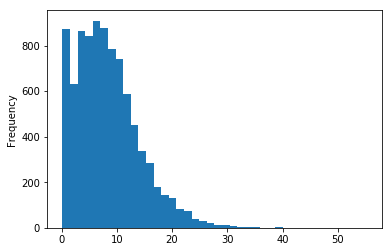

In [72]:
test = idv_logs_hangup_access_number_df[idv_logs_hangup_access_number_df['rec[1]_reason'].isna()]
test.end_duration.plot.hist(bins=40);

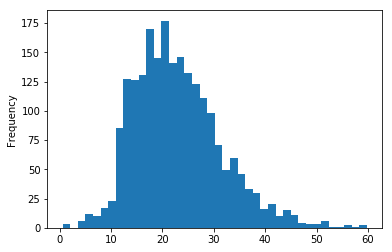

In [73]:
test = idv_logs_hangup_access_number_df[-idv_logs_hangup_access_number_df['rec[1]_reason'].isna()]
test.end_duration.plot.hist(bins=40);

In [74]:
# what they prefer as input
idv_logs_hangup_access_number_df[(idv_logs_hangup_access_number_df['rec[1]_reason'] == 'OK')]['rec[1]_inputmode'].value_counts(dropna=False, normalize=True)

dtmf      0.957018
speech    0.042982
Name: rec[1]_inputmode, dtype: float64